In [112]:
import pandas as pd
from pathlib import Path
import sys
import torch




sys.path.append("./")
sys.path.append(r"C:\Users\Federico\Documents\GitHub\pysical_locomotion")

population_cache = Path(
    r"D:\Dropbox (UCL)\Rotation_vte\Locomotion\analysis\ephys\population\data"
)

In [113]:
df = pd.read_parquet(population_cache / "FC_220435_BAA1101192_hairpin.parquet")
units = [c for c in df.columns[18:] if "shuffle" not in c]

# group every 5 frrame
# df = df.groupby(lambda x: x // 5).mean()

# remove rows with nans
df = df.dropna(axis=0)
df.reset_index(inplace=True, drop=True)


In [114]:
# split test/train
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# df = StandardScaler().fit_transform(df)
# df = (df - df.mean()) / df.std()

X = df[units]
Y = df[["v", "omega", "dv_500ms", "domega_500ms"]]

nrows_validation = int(len(X) * 0.2)
X_train, X_validation = X[:-nrows_validation], X[-nrows_validation:]
Y_train, Y_validation = Y[:-nrows_validation], Y[-nrows_validation:]

# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [115]:
# fit a linear regression model for each variale in Y on the training set
from sklearn.linear_model import LinearRegression

lr_v = LinearRegression().fit(X_train, Y_train["v"])
lr_omega = LinearRegression().fit(X_train, Y_train["omega"])
lr_dv = LinearRegression().fit(X_train, Y_train["dv_500ms"])
lr_domega = LinearRegression().fit(X_train, Y_train["domega_500ms"])

Pearson r: 0.4214425838392393
Spearman r: 0.15958566184364353


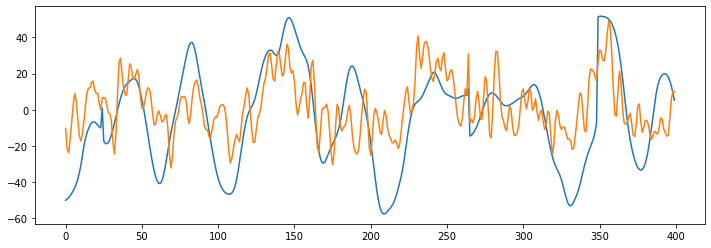

In [116]:
# lr_v.coef_.shape

yhat = X_validation.values @ lr_dv.coef_ + lr_dv.intercept_
y = Y_validation["dv_500ms"].values

# compute pearson r and r squared
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

print(f"Pearson r: {pearsonr(y, yhat)[0]}")
print(f"Spearman r: {r2_score(y, yhat)}")

# plot the results
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots( figsize=(12, 4))
plt.plot(y[0:400])
plt.plot(yhat[0:400] * 2)

[Text(0.5, 0, 'v'), Text(0, 0.5, 'dv')]

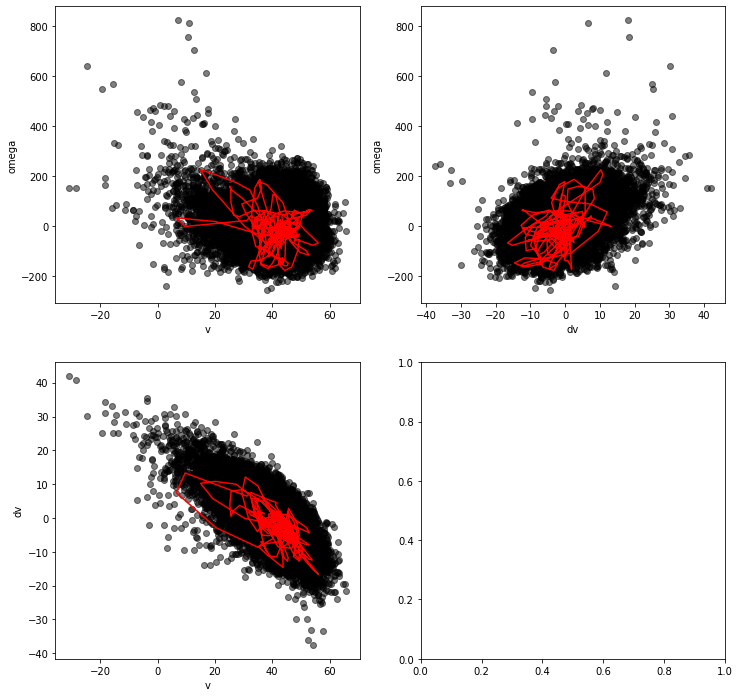

In [117]:
v_proj = X.values @ lr_v.coef_ + lr_v.intercept_
omega_proj = X.values @ lr_omega.coef_ + lr_omega.intercept_
dv_proj = X.values @ lr_dv.coef_ + lr_dv.intercept_


f, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.ravel()

axes[0].scatter(v_proj, omega_proj, color="k", alpha=.5)
axes[0].plot(v_proj[:250], omega_proj[:250], color="r")
axes[0].set(xlabel="v", ylabel="omega")

axes[1].scatter(dv_proj, omega_proj, color="k", alpha=.5)
axes[1].plot(dv_proj[:250], omega_proj[:250], color="r")
axes[1].set(xlabel="dv", ylabel="omega")

axes[2].scatter(v_proj, dv_proj, color="k", alpha=.5)
axes[2].plot(v_proj[:250], dv_proj[:250], color="r")
axes[2].set(xlabel="v", ylabel="dv")